In [1]:
import os

In [2]:
os.chdir('../..')

# Data Augmentation

In [3]:
import cv2
import dev.python.utils.data_augmentation as da
import PIL
import PIL.Image as Image
import numpy as np
import random

In [4]:
import imgaug as ia
import imgaug.augmenters as iaa

In [5]:
cover_img_dir = 'data/input/book_covers/'
background_img_dir = 'data/input/shops_atmosphere/'
augmented_img_output_dir = 'data/output/tests/augmented_covers/'

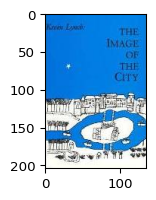

In [6]:
cover_img_cat = os.listdir(cover_img_dir)[0]
cover_img_file = os.listdir(cover_img_dir+cover_img_cat)[0]
cover_img_path = cover_img_dir+cover_img_cat+'/'+cover_img_file
cover_img = cv2.imread(cover_img_path)
ia.imshow(cover_img[:, :, ::-1])

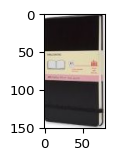

In [7]:
cover_img_cat = os.listdir(cover_img_dir)[0]
cover_img_file = os.listdir(cover_img_dir+cover_img_cat)[0]
cover_img_path = cover_img_dir+cover_img_cat+'/'+'0000004.jpg'
cover_img = cv2.imread(cover_img_path)
ia.imshow(cover_img[:, :, ::-1])

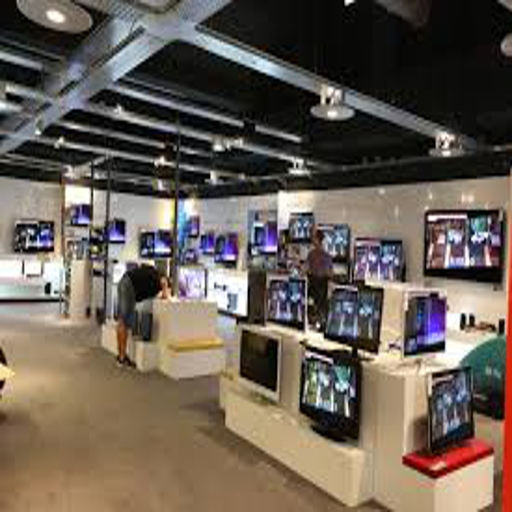

In [35]:
background_img_file = os.listdir(background_img_dir)[3]
background_img_path = background_img_dir+background_img_file
background_img = PIL.Image.open(background_img_path).resize((512,512))
background_img

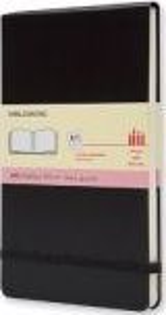

In [54]:
resized_cover_img = da.scale_cover_image(cover_img, background_img)
PIL.Image.fromarray(resized_cover_img[:, :, ::-1])

In [55]:
rotation = (random.uniform(0, 45), random.uniform(0, 45), random.uniform(0, 45))

cover_img_corners = da.get_image_corners(resized_cover_img)

M = da.transform(resized_cover_img,
          translation=(0, 0, 0),
          rotation=rotation,
          scaling=(1, 1, 1),
          shearing=(0, 0, 0))
proj_cover_img_corners = np.array([da.project_point(point, M) for point in cover_img_corners])

rotation, M, proj_cover_img_corners

((35.27144424441636, 28.447888349399168, 33.05033991381849),
 array([[ 2.93774400e+02, -1.33965766e+02,  2.37148043e+04],
        [ 1.71027696e+02,  3.15186643e+02, -1.24758175e+04],
        [ 6.40910308e-01,  2.71911420e-01,  2.31134702e+02]]),
 array([[103, -54],
        [215,  47],
        [-58, 274],
        [ 72, 272],
        [ 83, 157]]))

In [56]:
translation = da.find_translation(proj_cover_img_corners)
translation

array([58, 54])

In [57]:
i=0
while (proj_cover_img_corners<0).any():
    translation += i*10
    M = da.transform(resized_cover_img,
                  translation=(translation[0], translation[1], 0),
                  rotation=rotation,
                  scaling=(1, 1, 1),
                  shearing=(0, 0, 0))
    proj_cover_img_corners = np.array([da.project_point(point, M) for point in cover_img_corners])
    i+=1

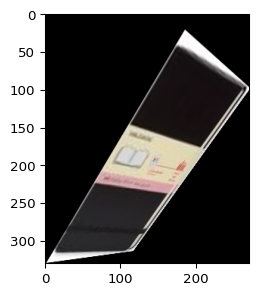

In [58]:
warped_cover_img_size = np.max(proj_cover_img_corners, axis=0)
warped_cover_img = cv2.warpPerspective(resized_cover_img, M, tuple(warped_cover_img_size))
ia.imshow(warped_cover_img[:, :, ::-1])

In [59]:
warped_cover_img_mask = da.create_img_mask(warped_cover_img)
warped_cover_img_mask

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0],
       [  0, 255, 255, ...,   0,   0,   0]], dtype=uint8)

In [60]:
center_background_img = (np.array(background_img.size)/2).astype(np.int)

In [61]:
position_cover_img_in_background = da.define_position_of_cover_in_background(proj_cover_img_corners[-1],
background_img)
position_cover_img_in_background

(116, 60)

In [62]:
background_img.paste(Image.fromarray(warped_cover_img[:, :, ::-1]),
position_cover_img_in_background,
Image.fromarray(warped_cover_img_mask))

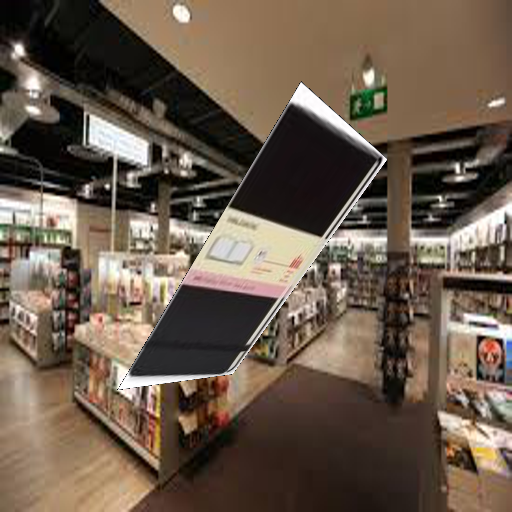

In [63]:
augmented_img = background_img.copy()
augmented_img

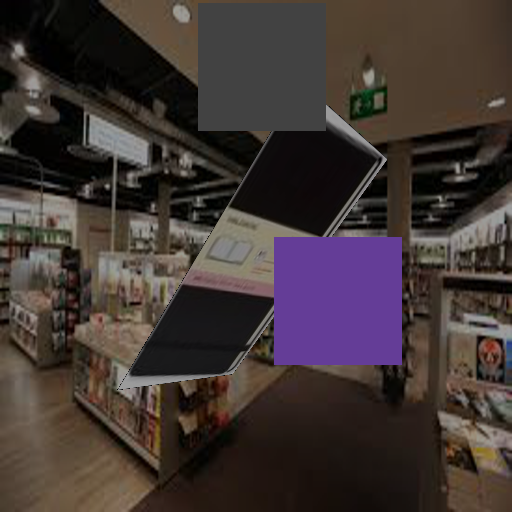

In [64]:
augmented_img_array = da.post_composition_augmentation(np.array(augmented_img))
augmented_img_array

In [65]:
filename = da.generate_file_path_name(cover_img_cat+'_'+cover_img_file.split('.')[0], proj_cover_img_corners[:-1]+position_cover_img_in_background, 0)
augmented_img_output_path = augmented_img_output_dir+filename

In [21]:
augmented_img_output_path

'data/output/tests/augmented_covers/Biography_0000943_0_166_115_355_121_123_361_286_351.jpg'

In [38]:
augmented_img_array.convert('RGB').save(augmented_img_output_path)

In [47]:
with(open('logs/logs.txt', 'a'))as f:
    f.write(cover_img_path+', '+background_img_path+', '+'_'.join([str(angle)for angle in rotation])+'\n')

In [35]:
l = os.listdir(cover_img_dir)
l.remove('main_dataset.csv')
l

['Art-Photography',
 'Biography',
 'Business-Finance-Law',
 'Childrens-Books',
 'Computing',
 'Crafts-Hobbies',
 'Crime-Thriller',
 'Dictionaries-Languages',
 'Entertainment',
 'Food-Drink',
 'Graphic-Novels-Anime-Manga',
 'Health',
 'History-Archaeology',
 'Home-Garden',
 'Humour',
 'Medical',
 'Mind-Body-Spirit',
 'Natural-History',
 'Personal-Development',
 'Poetry-Drama',
 'Reference',
 'Religion',
 'Romance',
 'Science-Fiction-Fantasy-Horror',
 'Science-Geography',
 'Society-Social-Sciences',
 'Sport',
 'Stationery',
 'Teaching-Resources-Education',
 'Technology-Engineering',
 'Teen-Young-Adult',
 'Transport',
 'Travel-Holiday-Guides']

# Training

In [53]:
os.getcwd()

'/home/app'

In [54]:
augmented_img_output_path = 'data/output/tests/augmented_covers/' + 'Art-Photography_0000001_1_148_29_292_32_142_213_280_215.jpg'

In [49]:
file_path = augmented_img_output_path
file_path.split('/')[-1].split('.')[0].split('_')[-8:]

['148', '29', '292', '32', '142', '213', '280', '215']

In [56]:
points = np.array(file_path.split('/')[-1].split('.')[0].split('_')[-8:]).reshape((4, 2)).astype(np.int)
points

array([[148,  29],
       [292,  32],
       [142, 213],
       [280, 215]])

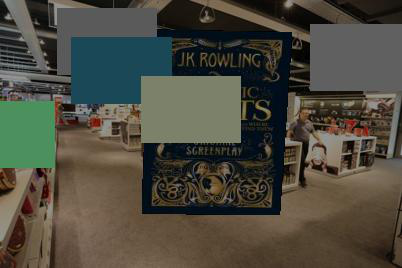

In [55]:
img = PIL.Image.open(augmented_img_output_path)
img

In [58]:
np.array(img)

array([[[35, 41, 37],
        [43, 49, 45],
        [49, 55, 51],
        ...,
        [26, 23, 18],
        [24, 21, 16],
        [24, 21, 16]],

       [[24, 30, 26],
        [26, 32, 28],
        [31, 37, 33],
        ...,
        [26, 23, 18],
        [25, 22, 17],
        [25, 22, 17]],

       [[21, 27, 23],
        [18, 24, 20],
        [21, 27, 23],
        ...,
        [26, 23, 18],
        [25, 22, 17],
        [25, 22, 17]],

       ...,

       [[54, 34, 27],
        [48, 28, 21],
        [45, 26, 19],
        ...,
        [46, 36, 27],
        [66, 56, 46],
        [68, 58, 48]],

       [[51, 30, 25],
        [47, 26, 21],
        [45, 26, 20],
        ...,
        [26, 17, 10],
        [44, 34, 25],
        [46, 36, 27]],

       [[51, 27, 25],
        [45, 24, 21],
        [45, 26, 22],
        ...,
        [24, 16, 13],
        [23, 13,  4],
        [25, 15,  6]]], dtype=uint8)

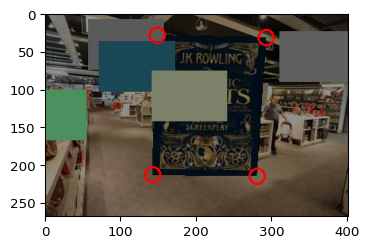

In [61]:
img_c = da.draw_circles(np.array(img), points)
ia.imshow(img_c)

# refacto

In [11]:
from importlib import reload

In [30]:
reload(da)

<module 'dev.python.utils.data_augmentation' from '/home/app/dev/python/utils/data_augmentation.py'>

In [31]:
im, p = da.end_to_end_transformation(cover_img, background_img)

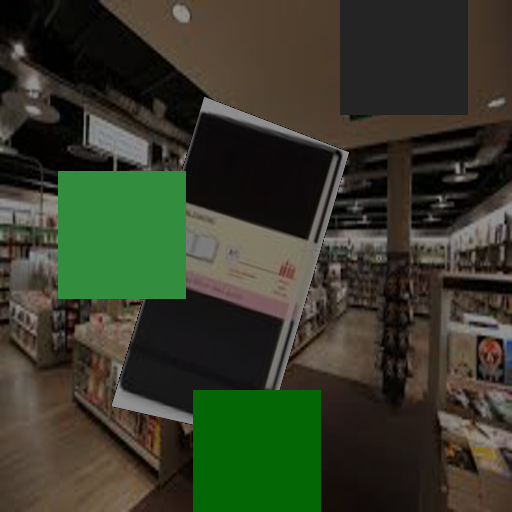

In [32]:
im

In [33]:
p

array([[204,  97],
       [349, 152],
       [111, 406],
       [265, 441]])

In [28]:
p

array([[201,  39],
       [254, 100],
       [  4, 387],
       [109, 323],
       [138, 233]])

In [23]:
augmented_image_dir='data/output/tests/augmented_covers/'

In [29]:
augmented_img_output_dir = augmented_image_dir
filename = da.generate_file_path_name(cover_img_cat+'_'+cover_img_file.split('.')[0], p, i)
augmented_img_output_path = augmented_img_output_dir+filename

NameError: name 'i' is not defined